In [1]:
# Setting Up the Environment 

import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import warnings
from matplotlib import pyplot as plt
from matplotlib import style

style.use('ggplot')

# Two valuable resources:
# https://www.youtube.com/watch?v=_T0l015ecK4         <-- Provides the scaffolding for this model
# https://www.youtube.com/watch?v=eXhCXobViJc&t=2s    <-- Explains the reason for using simulations

In [2]:
# Importing the Data

link = "https://docs.google.com/spreadsheets/d/1cDTfSnnegVhw3I6tLu6QVtPw3skCK6uG/export?format=xlsx&ouid=100559005023165146319&rtpof=true&sd=true"
data = pd.read_excel(link, sheet_name='Sheet1', index_col='date')
data.head()

,revenue
date,
2022-09-30,32716000000
2022-06-30,30709000000
2022-03-31,30718000000
2021-12-31,29288000000
2021-09-30,29661000000


In [3]:
# Data Cleaning

data.index = pd.to_datetime(data.index)
df = data.sort_values(by='date')
df['log_returns'] = np.log(df.revenue/df.revenue.shift(1))
df.dropna()

pd.options.display.float_format = lambda x : '{:.4f}'.format(x)
df.log_returns.describe()

count   130.0000
mean      0.0274
std       0.2108
min      -0.7728
25%      -0.0434
50%       0.0067
75%       0.0667
max       1.4324
Name: log_returns, dtype: float64

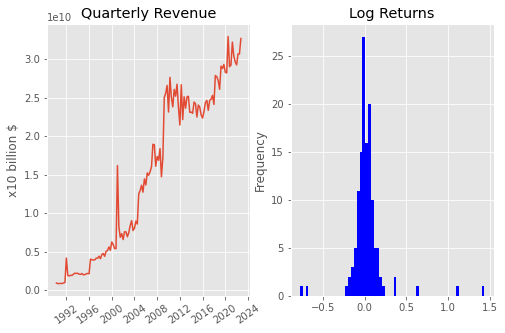

In [4]:
# Exploring the Dataset

plt.subplots(figsize=(8,5))

# Time-series plot
plt.subplot(1,2,1)
plt.plot(data)
plt.title('Quarterly Revenue')
plt.ylabel('x10 billion $')
plt.xticks(rotation = 35)

# Histogram
plt.subplot(1,2,2)
plt.hist(df.log_returns, bins=65, color='b')
plt.title('Log Returns')
plt.ylabel('Frequency')

plt.show()

In [5]:
# Parameters for Simulation

num_sim = 10_000
num_periods = 8
simulation_df = pd.DataFrame()


# Running the Simulation

for x in range(num_sim):
    count = 0
    last_rev = df.revenue[-1]
    mean_return = df.log_returns.mean()
    st_dev = df.log_returns.std()

    forecast_series = [] 

    rev_proj = last_rev * (1 + np.random.normal(mean_return, st_dev))
    forecast_series.append(rev_proj)  

    for y in range(num_periods):
        if count == num_periods - 1:
            break
        rev_proj = forecast_series[count] * (1 + np.random.normal(mean_return, st_dev)) 
        forecast_series.append(rev_proj) 
        count += 1

    simulation_df[x] = forecast_series

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [6]:
def print_statistics(array1, array2):
    '''
    User-defined function:
    prints selected statistics.
    
    Paramters
    =========
    array: ndarray
        object to generate statistics on
    '''
    sta1 = stats.describe(array1)
    sta2 = stats.describe(array2)

    print(95 * '=')
    print(f'{"statistic": >16} {"yr 1": >16} {"yr 2": >16}')
    print(50 * '=')
    print(f'{"min": >16} {sta1[1][0]: >16,.0f} {sta2[1][0]: >16,.0f}')
    print(f'{"max": >16} {sta1[1][1]: >16,.0f} {sta2[1][1]: >16,.0f}')
    print(f'{"mean": >16} {sta1[2]: >16,.0f} {sta2[2]: >16,.0f}')
    print(f'{"median": >16} {np.percentile(array1, 50): >16,.0f} {np.percentile(array2, 50): >16,.0f}')
    print(f'{"std": >16} {np.sqrt(sta1[3]): >16,.0f} {np.sqrt(sta2[3]): >16,.0f}')
    

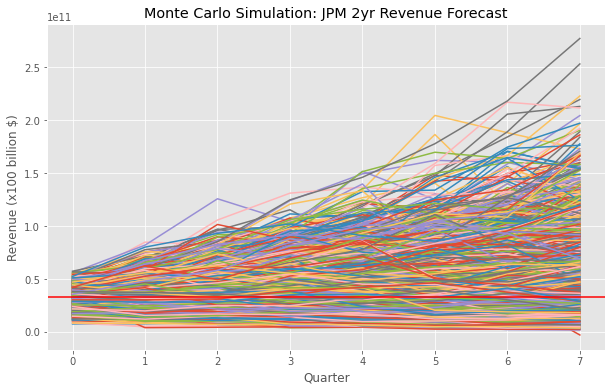

       statistic             yr 1             yr 2
             min    3,865,203,401   -2,878,147,153
             max  131,175,075,441  277,389,639,180
            mean   36,579,674,188   40,583,697,184
          median   34,372,164,948   34,893,959,871
             std   15,429,932,033   25,190,890,981


In [7]:
# Plotting the Simulation

plt.figure(figsize=(10,6))
plt.plot(simulation_df)
plt.title('Monte Carlo Simulation: JPM 2yr Revenue Forecast')
plt.axhline(y = last_rev, color = 'r', linestyle = '-')
plt.xlabel('Quarter')
plt.ylabel('Revenue (x100 billion $)')
plt.show()

# Printing the Accompanying Summary Statistics

_1yr_sim = simulation_df.loc[3,:].values.flatten().tolist()
_2yr_sim = simulation_df.loc[7:].values.flatten().tolist()
print_statistics(_1yr_sim, _2yr_sim)

In [8]:
# Estimating Probablities According the Simulation

percentile = list(range(0, 110, 10))
probability = percentile[::-1]
_1yr_fore = np.percentile(_1yr_sim, percentile)
_2yr_fore = np.percentile(_2yr_sim, percentile)

dict = {'1yr Forecast': _1yr_fore, '2yr Forecast': _2yr_fore}
results = pd.DataFrame(dict, index=probability)

pd.options.display.float_format = lambda x : '{:,.0f}'.format(x)
print(95*'=')
print('This table displays the predicted probability that the specified')
print('    amount of revenue or more is met at each time interval.')
results

This table displays the predicted probability that the specified
    amount of revenue or more is met at each time interval.


,1yr Forecast,2yr Forecast
100,"3,865,203,401","-2,878,147,153"
90,"18,949,261,567","15,494,353,995"
80,"23,407,584,617","20,576,053,319"
70,"27,208,895,796","25,219,367,862"
60,"30,783,929,611","29,618,971,265"
50,"34,372,164,948","34,893,959,871"
40,"38,366,443,374","40,724,516,502"
30,"42,773,854,781","47,873,376,275"
20,"48,315,744,396","56,947,929,252"
10,"57,025,897,191","72,403,904,870"


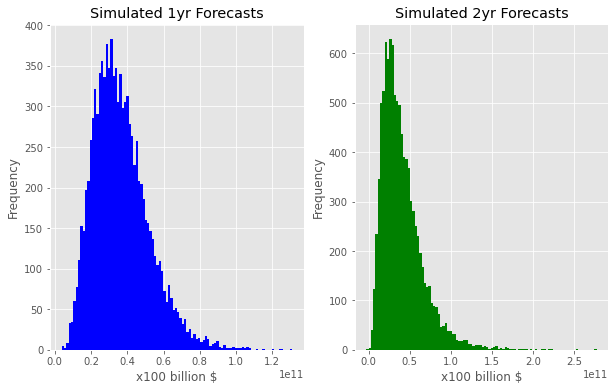

In [9]:
# Histogram of Simulated Forecasts

plt.subplots(figsize=(10,6))

plt.subplot(1,2,1)
plt.hist(_1yr_sim, bins=100, color='b')
plt.title('Simulated 1yr Forecasts')
plt.xlabel('x100 billion $')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(_2yr_sim, bins=100, color='g')
plt.title('Simulated 2yr Forecasts')
plt.xlabel('x100 billion $')
plt.ylabel('Frequency')

plt.show()